# This Notebook contains code to train mask classifiers the compiled image dataset

Face Analysis
* [Feature Extraction](#feat_ext)
* [Machine Learning Classifiers](#ml) 
* [Deep Learning with Keras](#dl)

Face Analysis with Additional Mask Annotation
* TODO: need to complete this part

In [2]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as patches
import tensorflow as tf
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential

from mtcnn.mtcnn import MTCNN # TODO: what is this?

# Load in Image Data and Labels from the Compiled Dataset



In [3]:
train = pd.read_csv('compiled_labels_km-annotated.csv')

display(train)



,name,x1,x2,y1,y2,classname,image_file_dir
0,1801.jpg,451,186,444,511,face_no_mask,../Dataset/mask_image_data/images/
1,1802.jpg,160,151,108,114,face_mask,../Dataset/mask_image_data/images/
2,1802.jpg,110,71,163,201,face_with_mask,../Dataset/mask_image_data/images/
3,1803.jpg,147,200,141,120,face_mask,../Dataset/mask_image_data/images/
4,1803.jpg,126,75,177,258,face_with_mask,../Dataset/mask_image_data/images/
...,...,...,...,...,...,...,...
20312,new_76.jpg,191,187,282,382,face_no_mask,../Dataset/yolo/images/valid/
20313,new_78.jpg,126,200,335,370,face_no_mask,../Dataset/yolo/images/valid/
20314,new_79.jpg,138,212,305,332,face_no_mask,../Dataset/yolo/images/valid/
20315,new_90.jpg,133,263,346,316,face_no_mask,../Dataset/yolo/images/valid/


# Plot Some Annotations

asian_mask20.jpg has 1 label(s)
19036    ../Dataset/yolo/images/train/asian_mask20.jpg
Name: image_file_dir, dtype: object
['face_with_mask']


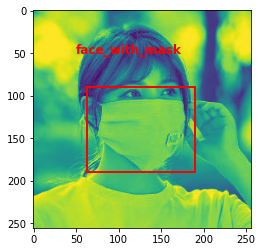

new_168.jpg has 2 label(s)
19742    ../Dataset/yolo/images/train/new_168.jpg
20253    ../Dataset/yolo/images/valid/new_168.jpg
Name: image_file_dir, dtype: object
['face_no_mask', 'face_no_mask']


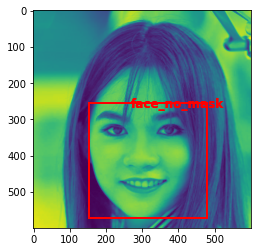

maksssksksss851.png has 1 label(s)
14707    ../Dataset/dataset_4/images/maksssksksss851.png
Name: image_file_dir, dtype: object
['face_with_mask']


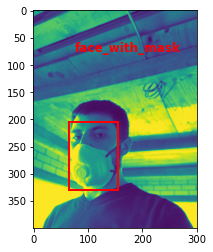

1815.jpg has 1 label(s)
37    ../Dataset/mask_image_data/images/1815.jpg
Name: image_file_dir, dtype: object
['face_no_mask']


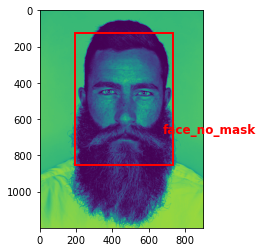

4497.png has 2 label(s)
7442    ../Dataset/mask_image_data/images/4497.png
7443    ../Dataset/mask_image_data/images/4497.png
Name: image_file_dir, dtype: object
['face_with_mask', 'face_mask']


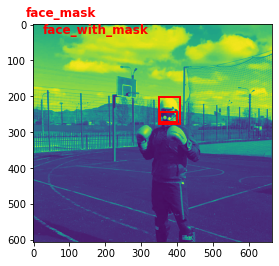

3700.png has 1 label(s)
5075    ../Dataset/mask_image_data/images/3700.png
Name: image_file_dir, dtype: object
['face_other_covering']


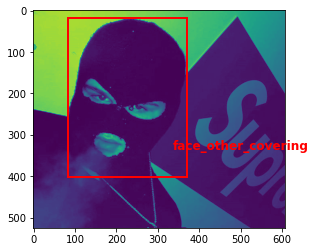

2251.png has 2 label(s)
1248    ../Dataset/mask_image_data/images/2251.png
1249    ../Dataset/mask_image_data/images/2251.png
Name: image_file_dir, dtype: object
['face_with_mask', 'face_mask']


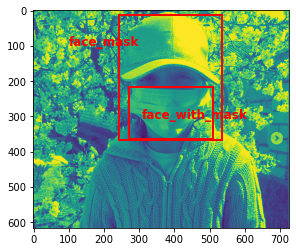

1970.jpg has 2 label(s)
467    ../Dataset/mask_image_data/images/1970.jpg
468    ../Dataset/mask_image_data/images/1970.jpg
Name: image_file_dir, dtype: object
['face_other_covering', 'face_other_covering']


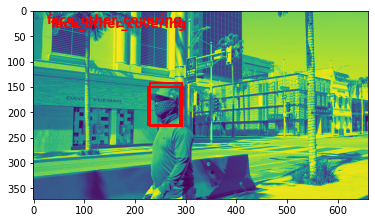

2221.png has 2 label(s)
1188    ../Dataset/mask_image_data/images/2221.png
1189    ../Dataset/mask_image_data/images/2221.png
Name: image_file_dir, dtype: object
['face_with_mask', 'face_mask']


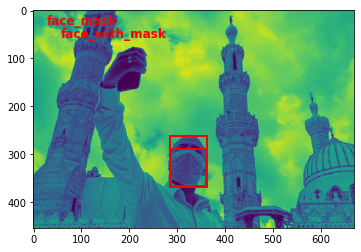

2372.png has 2 label(s)
1586    ../Dataset/mask_image_data/images/2372.png
1587    ../Dataset/mask_image_data/images/2372.png
Name: image_file_dir, dtype: object
['face_with_mask', 'face_mask']


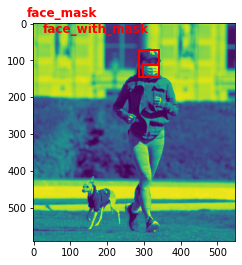

In [4]:
import random
def plot_image_with_all_bboxes(img_nm):
    dat = train[train['name'] == img_nm]
    print(img_nm,"has",len(dat),'label(s)')
    print(dat['image_file_dir']+img_nm)
    
    img = cv2.imread(dat.iloc[0]['image_file_dir']+img_nm,cv2.IMREAD_GRAYSCALE)
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    class_name_ls = []
    for index,row in dat.iterrows():
        rect = patches.Rectangle(
            (row['x1'],row['x2']),
            row['y1'],
            row['y2'],
            linewidth=2,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
        ax.text(row['y2']-50, row['y2']-50, row['classname'], fontsize=12,color='r',fontweight='bold')
        class_name_ls.append(row['classname'])
    print(class_name_ls)
    plt.show()
name_ls =list(set(train['name']))
random.shuffle(name_ls)

for f in name_ls[0:10]:
    plot_image_with_all_bboxes(f)
    
    

# TODO: Check for Duplicate Images?


# Plot Distribution of the Labels 

face_with_mask         11767
face_mask               4306
face_no_mask            2872
face_other_covering     1372
Name: classname, dtype: int64


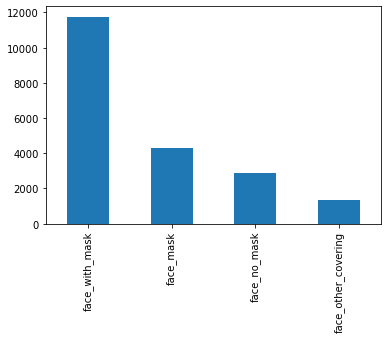

In [5]:
train.classname.value_counts().plot(kind='bar')
print(train.classname.value_counts())


# Get only training data corresponding faces

In [6]:
train = train.reset_index()
train_face = train[train['classname'] != 'face_mask']
# Drop annotations for label face_other_covering
train_face = train_face[train_face['classname']!='face_other_covering']
train_face = train_face.reset_index()
display(train_face)



,level_0,index,name,x1,x2,y1,y2,classname,image_file_dir
0,0,0,1801.jpg,451,186,444,511,face_no_mask,../Dataset/mask_image_data/images/
1,2,2,1802.jpg,110,71,163,201,face_with_mask,../Dataset/mask_image_data/images/
2,4,4,1803.jpg,126,75,177,258,face_with_mask,../Dataset/mask_image_data/images/
3,6,6,1804.jpg,112,113,150,194,face_with_mask,../Dataset/mask_image_data/images/
4,7,7,1805.jpg,728,180,125,156,face_with_mask,../Dataset/mask_image_data/images/
...,...,...,...,...,...,...,...,...,...
14634,20312,20312,new_76.jpg,191,187,282,382,face_no_mask,../Dataset/yolo/images/valid/
14635,20313,20313,new_78.jpg,126,200,335,370,face_no_mask,../Dataset/yolo/images/valid/
14636,20314,20314,new_79.jpg,138,212,305,332,face_no_mask,../Dataset/yolo/images/valid/
14637,20315,20315,new_90.jpg,133,263,346,316,face_no_mask,../Dataset/yolo/images/valid/


In [7]:
print(set(train_face['classname']))

{'face_with_mask', 'face_no_mask'}


<a id='feat_ext'></a>
# Extract only faces from images
(This may take several minutes to run)

In [76]:
# Extracts images and places the information into a list (data) of 50x50 pixel images
img_size=224#50
data=[]
path="../Dataset/compiled_data/"
to_drop = []
    
for index,row in train_face.iterrows(): # only extract face annotation (NOT mask annotations)
    # reads in the image and converts it to greyscale 
    img_array=cv2.imread(row['image_file_dir']+row['name'],cv2.COLOR_BGR2RGB)#IMREAD_GRAYSCALE)#
    # crops the image to only include the face 
    crop_image = img_array[row['x2']:(row['y2']+row['x2']),
                           row['x1']:(row['y1']+row['x1'])]
    # resizes the image to 50x50
    try:
        new_img_array=cv2.resize(crop_image,(img_size,img_size))
    #         plt.imshow(new_img_array)
    #         plt.show()
        data.append([new_img_array,row['classname']])#new_img_array[1]])
    except:
        print(row['name'],"cannot be formatted")
        plt.imshow(img_array)
        plt.show()
        # keep track of those without the appropriate information and drop from the dataframe
        to_drop.append(index)
        data.append(-1)
    




# Some annotations of small faces cannot be included as we cannot generate a 50x50 image with them so will exclude for now
NOTE: other annotations of these same image files will be retained as they are valuable to our analysis

# Plot Some Extracted Faces
two from each dataset

In [77]:
# get INDICIES of two images from each data source
index_ls = []
for d in list(set(train_face['image_file_dir'])):# will be different for each dataset
    index_ls+=list(train_face[train_face['image_file_dir'] == d].index)[0:2]


[[[ 28  45  38]
  [ 33  49  42]
  [ 27  44  39]
  ...
  [ 70  86 127]
  [ 78  95 134]
  [ 61  79 116]]

 [[ 24  42  35]
  [ 32  47  43]
  [ 25  42  38]
  ...
  [ 68  84 121]
  [ 82  98 134]
  [ 73  90 126]]

 [[ 23  39  33]
  [ 28  43  39]
  [ 22  38  35]
  ...
  [ 68  81 115]
  [ 85  97 130]
  [ 69  82 114]]

 ...

 [[ 55  67  81]
  [ 40  51  69]
  [ 39  49  69]
  ...
  [113 116 118]
  [113 117 118]
  [114 118 119]]

 [[ 55  67  82]
  [ 47  64  81]
  [ 37  54  75]
  ...
  [117 122 121]
  [114 120 118]
  [114 118 118]]

 [[ 49  62  76]
  [ 45  63  80]
  [ 44  63  82]
  ...
  [116 121 120]
  [113 118 117]
  [112 117 116]]]
Shape: (224, 224, 3)


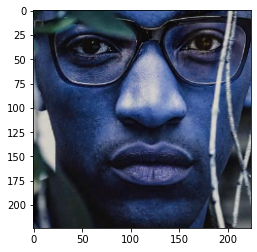


[[[ 25  42  85]
  [ 22  40  86]
  [ 24  42  89]
  ...
  [ 58  72 104]
  [ 52  66  95]
  [ 44  57  86]]

 [[ 30  47  90]
  [ 32  50  95]
  [ 23  41  88]
  ...
  [ 47  60  92]
  [ 49  63  92]
  [ 49  63  92]]

 [[ 25  42  85]
  [ 27  45  90]
  [ 26  44  91]
  ...
  [ 40  53  86]
  [ 45  59  88]
  [ 37  51  80]]

 ...

 [[229 227 216]
  [228 226 215]
  [228 226 215]
  ...
  [249 248 243]
  [249 248 244]
  [249 248 244]]

 [[228 226 215]
  [227 225 214]
  [227 225 214]
  ...
  [249 248 243]
  [249 248 244]
  [249 248 244]]

 [[228 226 215]
  [227 225 214]
  [227 225 214]
  ...
  [249 249 243]
  [249 248 244]
  [249 248 244]]]
Shape: (224, 224, 3)


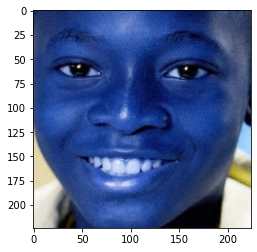


[[[ 20  25  26]
  [ 25  30  31]
  [ 27  32  33]
  ...
  [ 39  44  47]
  [ 42  47  50]
  [ 42  49  51]]

 [[ 32  35  39]
  [ 41  45  46]
  [ 41  45  46]
  ...
  [ 42  46  47]
  [ 45  49  50]
  [ 46  51  52]]

 [[ 49  52  55]
  [ 45  49  50]
  [ 38  42  43]
  ...
  [ 40  45  46]
  [ 46  50  51]
  [ 49  53  54]]

 ...

 [[145 137 137]
  [159 151 151]
  [166 158 158]
  ...
  [134 126 119]
  [134 126 119]
  [131 123 116]]

 [[144 136 136]
  [158 150 150]
  [165 157 157]
  ...
  [133 125 118]
  [134 126 119]
  [131 123 116]]

 [[141 133 131]
  [156 148 148]
  [164 156 157]
  ...
  [133 125 118]
  [134 126 119]
  [131 123 116]]]
Shape: (224, 224, 3)


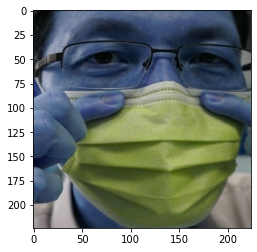


[[[ 42  49  58]
  [ 46  53  63]
  [ 53  61  73]
  ...
  [ 22  25  23]
  [ 22  25  23]
  [ 22  25  23]]

 [[ 43  50  59]
  [ 46  54  64]
  [ 53  62  74]
  ...
  [ 22  25  23]
  [ 22  25  23]
  [ 22  25  23]]

 [[ 45  52  61]
  [ 49  56  66]
  [ 55  64  76]
  ...
  [ 22  25  23]
  [ 22  25  23]
  [ 22  25  23]]

 ...

 [[ 94 153 197]
  [ 87 144 187]
  [ 73 125 167]
  ...
  [ 45  29  16]
  [ 45  29  16]
  [ 45  29  16]]

 [[ 75 131 174]
  [ 73 128 171]
  [ 71 121 163]
  ...
  [ 45  29  16]
  [ 45  29  16]
  [ 45  29  16]]

 [[ 66 121 164]
  [ 67 120 163]
  [ 70 119 162]
  ...
  [ 45  29  16]
  [ 45  29  16]
  [ 45  29  16]]]
Shape: (224, 224, 3)


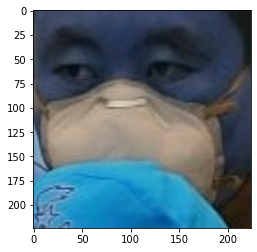


[[[75 74 70]
  [75 74 70]
  [73 71 69]
  ...
  [24 32 25]
  [25 33 26]
  [25 33 26]]

 [[75 74 70]
  [75 74 70]
  [74 71 69]
  ...
  [24 32 25]
  [25 33 26]
  [25 33 26]]

 [[77 74 72]
  [77 74 72]
  [75 71 70]
  ...
  [26 34 26]
  [27 35 28]
  [27 35 28]]

 ...

 [[20 25 24]
  [20 25 24]
  [20 25 24]
  ...
  [23 33 44]
  [22 32 42]
  [22 32 42]]

 [[20 25 24]
  [20 25 24]
  [20 25 24]
  ...
  [23 33 44]
  [22 32 42]
  [22 32 42]]

 [[20 25 24]
  [20 25 24]
  [20 25 24]
  ...
  [23 33 44]
  [22 32 42]
  [22 32 42]]]
Shape: (224, 224, 3)


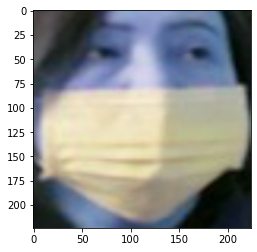


[[[181 198 217]
  [181 198 217]
  [182 198 217]
  ...
  [ 35  26  11]
  [ 35  26  12]
  [ 35  26  12]]

 [[181 198 217]
  [181 198 217]
  [182 198 217]
  ...
  [ 35  26  12]
  [ 35  26  12]
  [ 35  26  12]]

 [[182 199 214]
  [182 199 214]
  [183 198 215]
  ...
  [ 34  25  12]
  [ 33  25  13]
  [ 33  25  13]]

 ...

 [[159 191 222]
  [159 191 222]
  [158 189 222]
  ...
  [ 91  85  81]
  [ 92  85  83]
  [ 92  85  83]]

 [[160 191 222]
  [160 191 222]
  [159 190 222]
  ...
  [ 90  83  80]
  [ 91  84  81]
  [ 91  84  81]]

 [[160 191 222]
  [160 191 222]
  [159 190 222]
  ...
  [ 90  83  80]
  [ 91  84  81]
  [ 91  84  81]]]
Shape: (224, 224, 3)


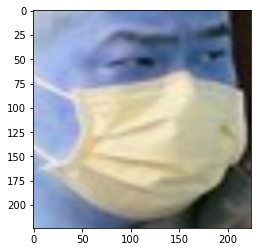


[[[ 48  53  86]
  [ 57  62  95]
  [ 58  63  95]
  ...
  [ 87  96  90]
  [ 88 100  94]
  [ 83  97  90]]

 [[ 43  50  85]
  [ 48  55  91]
  [ 56  64  99]
  ...
  [100 114 105]
  [100 117 107]
  [ 96 115 105]]

 [[ 51  60  97]
  [ 53  62 100]
  [ 58  67 106]
  ...
  [128 146 133]
  [118 139 126]
  [114 138 125]]

 ...

 [[  5   5  20]
  [ 10  10  33]
  [ 46  57  92]
  ...
  [137 143 169]
  [ 72  75 100]
  [ 61  60  84]]

 [[  6   3  22]
  [ 10   8  33]
  [ 44  54  88]
  ...
  [147 152 173]
  [ 81  82 103]
  [ 61  59  79]]

 [[  8   3  24]
  [ 11   7  33]
  [ 38  45  78]
  ...
  [138 140 156]
  [ 77  77  93]
  [ 51  47  63]]]
Shape: (224, 224, 3)


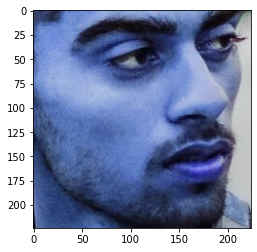


[[[ 50  85 157]
  [ 54  92 164]
  [ 58  98 170]
  ...
  [  6   8   9]
  [  3   6  10]
  [  3   4   7]]

 [[ 49  84 157]
  [ 52  90 162]
  [ 56  96 168]
  ...
  [  8   9  12]
  [  6   7  11]
  [  5   5   8]]

 [[ 49  84 157]
  [ 49  86 158]
  [ 54  94 166]
  ...
  [  8   7  14]
  [  6   5  12]
  [  6   5   9]]

 ...

 [[ 59 142 180]
  [ 58 143 181]
  [ 55 141 181]
  ...
  [  6   8  16]
  [  5   8  15]
  [  6   8  17]]

 [[ 59 142 180]
  [ 58 143 181]
  [ 56 141 181]
  ...
  [  6   8  16]
  [  5   7  15]
  [  6   7  17]]

 [[ 59 142 180]
  [ 57 142 180]
  [ 56 141 181]
  ...
  [  6   8  16]
  [  6   8  16]
  [  7   8  17]]]
Shape: (224, 224, 3)


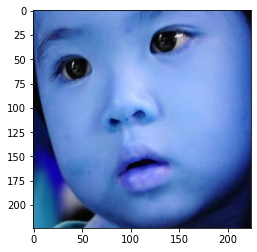


[[[162 158 164]
  [149 145 151]
  [123 120 125]
  ...
  [162 159 165]
  [160 158 164]
  [160 158 164]]

 [[135 131 137]
  [124 120 126]
  [ 80  77  83]
  ...
  [162 159 165]
  [160 158 164]
  [160 158 164]]

 [[153 151 157]
  [ 96  94 100]
  [ 65  62  68]
  ...
  [162 159 165]
  [160 158 164]
  [160 158 164]]

 ...

 [[116 114 120]
  [116 114 120]
  [117 115 121]
  ...
  [ 61  45  46]
  [ 61  45  46]
  [ 54  38  39]]

 [[117 115 121]
  [116 114 120]
  [116 113 119]
  ...
  [ 63  46  47]
  [ 64  47  48]
  [ 62  44  45]]

 [[115 113 119]
  [115 113 119]
  [116 113 120]
  ...
  [ 58  42  43]
  [ 66  49  49]
  [ 67  49  50]]]
Shape: (224, 224, 3)


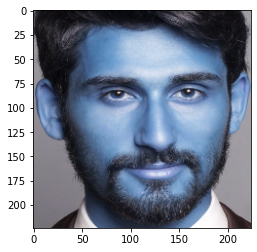


[[[184 234 255]
  [180 232 255]
  [173 227 253]
  ...
  [ 53 113 149]
  [ 47  98 132]
  [ 58 103 136]]

 [[200 244 250]
  [200 246 253]
  [195 244 254]
  ...
  [ 57 113 149]
  [ 52 100 134]
  [ 58 102 133]]

 [[214 251 249]
  [214 253 252]
  [211 253 255]
  ...
  [ 62 114 151]
  [ 58 103 137]
  [ 62 103 135]]

 ...

 [[173 188 213]
  [172 187 210]
  [172 185 207]
  ...
  [129 155 190]
  [122 152 188]
  [118 150 188]]

 [[172 186 205]
  [172 187 206]
  [173 186 205]
  ...
  [129 154 189]
  [122 149 185]
  [117 146 182]]

 [[170 182 200]
  [171 184 202]
  [173 185 204]
  ...
  [129 154 188]
  [121 147 181]
  [113 139 175]]]
Shape: (224, 224, 3)


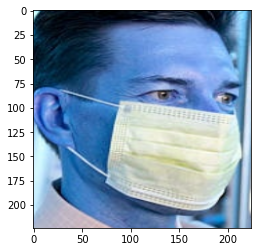

In [78]:
# show a few extracted faces:
for i in index_ls:
    print(data[i][0])
    print("Shape:",data[i][0].shape)
    plt.imshow(data[i][0])
    plt.show()
    print()


# Drop excluded annotations 
Drop elements in data that are -1 
Drop rows in train_face with indicies in to_drop

In [79]:
# Exclude annotations that could not be formatted
train_face = train_face.drop(to_drop)

initial_len = len(data)
data = [x for x in data if x != -1]

print("Dropped",len(to_drop),"images from train_face")
print("Dropped",initial_len-len(data),"faces from data")


Dropped 0 images from train_face
Dropped 0 faces from data


# Extract Labels and Features as x and y
### Convert labels to feature vector of 0's and 1's

In [80]:
# Extracts labels (mask/no mask) and features (50x50 vector of face image) and places them into x and y lists respectively
x=[]
y=[]
for features, labels in data:
    x.append(features)
    y.append(labels)
from sklearn.preprocessing import LabelEncoder
lbl=LabelEncoder()
y=lbl.fit_transform(y)
print("y:",y)
print("x:",x[0:5])



y: [0 1 1 ... 0 0 0]
x: [array([[[162, 158, 164],
        [149, 145, 151],
        [123, 120, 125],
        ...,
        [162, 159, 165],
        [160, 158, 164],
        [160, 158, 164]],

       [[135, 131, 137],
        [124, 120, 126],
        [ 80,  77,  83],
        ...,
        [162, 159, 165],
        [160, 158, 164],
        [160, 158, 164]],

       [[153, 151, 157],
        [ 96,  94, 100],
        [ 65,  62,  68],
        ...,
        [162, 159, 165],
        [160, 158, 164],
        [160, 158, 164]],

       ...,

       [[116, 114, 120],
        [116, 114, 120],
        [117, 115, 121],
        ...,
        [ 61,  45,  46],
        [ 61,  45,  46],
        [ 54,  38,  39]],

       [[117, 115, 121],
        [116, 114, 120],
        [116, 113, 119],
        ...,
        [ 63,  46,  47],
        [ 64,  47,  48],
        [ 62,  44,  45]],

       [[115, 113, 119],
        [115, 113, 119],
        [116, 113, 120],
        ...,
        [ 58,  42,  43],
        [ 66,  49,  49],

<a id='split'></a>
### Partition Training set to use part for evaluating (because submission set is unlabelled)

In [126]:
import numpy as np
from sklearn.model_selection import train_test_split
sz = 0.2# 0.8 # size of test set partition

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=sz, random_state=42)


print("Full labelled dataset size:",len(x))
print("Splitting data into training/testing set with a "+str(sz*100)+"% partition")
print("Training set size:",len(x_train))
print("Test set size:",len(x_test))




Full labelled dataset size: 14621
Splitting data into training/testing set with a 20.0% partition
Training set size: 11696
Test set size: 2925


<a id='dl'></a>

# Deep learning 

# Using Abdul's methods
[Partition Data](#split)

In [127]:
x_train = np.asarray(x_train)# set of 50x_train50 arrays representing pix_trainel intensities for each image
print("x.shape",x_train.shape)
# x_train = x_train.reshape(x_train.shape[0],x_train.shape[1]*x_train.shape[2])
print("y:",y_train)

# do same for test dataset
x_test = np.asarray(x_test)
print("\nx_test.shape",x_train.shape)


x.shape (11696, 224, 224, 3)
y: [0 1 1 ... 0 1 1]

x_test.shape (11696, 224, 224, 3)


In [128]:
#normalize the data
x_train = x_train/255.0

# do same for test dataset
x_test = x_test/255.0


In [129]:
y_train = np.array(y_train)
print (y_train.shape)

# do same for test dataset
y_test = np.array(y_test)
print (y_test.shape)


(11696,)
(2925,)


In [130]:
import pickle # module implements binary protocols

pickle_out = open("x_train.pickle",'wb') # "w" - Write - Opens a file for writing, creates the file if it does not ex_trainist . b = binary
pickle.dump(x_train,pickle_out)
print (pickle.dump(x_train,pickle_out))
pickle_out.close



None


<function BufferedWriter.close>

In [131]:
pickle_out = open('y_train.pickle','wb')
pickle.dump(y_train,pickle_out)
print (pickle.dump(y_train,pickle_out))
pickle_out.close

None


<function BufferedWriter.close>

In [132]:
pickle_in = open('x_train.pickle','rb')
x_train = pickle.load(pickle_in)
print(x_train)

pickle_in = open('y_train.pickle','rb')
#y = pickle.load(pickle_in)
y_train = pickle.load(file= pickle_in,  fix_imports=True)
print(y_train)




[[[[0.94117647 0.96470588 0.94509804]
   [0.94117647 0.96470588 0.94509804]
   [0.94117647 0.96470588 0.94509804]
   ...
   [0.9254902  0.94901961 0.92941176]
   [0.9254902  0.94901961 0.92941176]
   [0.9254902  0.94901961 0.92941176]]

  [[0.94117647 0.96470588 0.94509804]
   [0.94117647 0.96470588 0.94509804]
   [0.94117647 0.96470588 0.94509804]
   ...
   [0.9254902  0.94901961 0.92941176]
   [0.9254902  0.94901961 0.92941176]
   [0.9254902  0.94901961 0.92941176]]

  [[0.94117647 0.96470588 0.94509804]
   [0.94117647 0.96470588 0.94509804]
   [0.94117647 0.96470588 0.94509804]
   ...
   [0.9254902  0.94901961 0.92941176]
   [0.9254902  0.94901961 0.92941176]
   [0.9254902  0.94901961 0.92941176]]

  ...

  [[0.96078431 0.97254902 0.96470588]
   [0.96078431 0.97254902 0.96470588]
   [0.96078431 0.97254902 0.96470588]
   ...
   [0.95294118 0.90588235 0.91372549]
   [0.93333333 0.88627451 0.89411765]
   [0.9254902  0.87843137 0.88235294]]

  [[0.96078431 0.97254902 0.96470588]
   [0.9

## Deep learning model for training - Transfer Learning



In [133]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [134]:
model = tf.keras.applications.mobilenet.MobileNet() # pre-trained model
#model = tensorflow.keras.applications.mobilenet.MobileNet() # pre-trained model
# to read https://deeplizard.com/learn/video/OO4HD-1wRN8



In [135]:
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

## Transfer learning

In [136]:
base_input = model.layers[0].input
base_input

<tf.Tensor 'input_4:0' shape=(None, 224, 224, 3) dtype=float32>

In [137]:
base_output = model.layers[-4].output
base_output

<tf.Tensor 'dropout/cond_3/Identity:0' shape=(None, 1, 1, 1024) dtype=float32>

In [138]:
Flat_layer = layers.Flatten()(base_output)
final_output = layers.Dense(1)(Flat_layer) # 0 , 1
final_output = layers.Activation(activation='sigmoid')(final_output) # it was final_ouput 

In [139]:
# I create new model with my new layers 
new_model = keras.Model(inputs = base_input, outputs = final_output)



In [140]:
# I would chek the last layer (sigmoid)
just_to_check = new_model.layers[-1].output
just_to_check



<tf.Tensor 'activation_3/Sigmoid:0' shape=(None, 1) dtype=float32>

In [141]:
new_model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)     

## settings for binary classificaiton (Face mask/without mask)

In [142]:
new_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])





In [143]:
new_model.fit(x_train,y_train,epochs=1,validation_split= 0.1)
# TODO: remove validation split since we will validate on training or does this use it in the training?




329/329 [==============================] - 758s 2s/step - loss: 0.1086 - accuracy: 0.9606 - val_loss: 0.2588 - val_accuracy: 0.9248


In [144]:
new_model.save('my_model_new_larger_training_set.h5')


## Evaluate model
#### Plot Confusion Matrix

In [150]:
# perform prediction
pred = new_model.predict(x=x_test,batch_size=32)



In [151]:
confusion_matrix(y_test,[int(round(x,0)) for x in list(pred[:,0])]) # true, predicted

array([[ 371,  172],
       [   3, 2379]])

In [149]:
len(y_test)#[:,0])



2925

In [147]:
len([int(round(x,0)) for x in list(pred[:,0])])

11697

TN: 371  FP: 172  FN: 3  TP: 2379


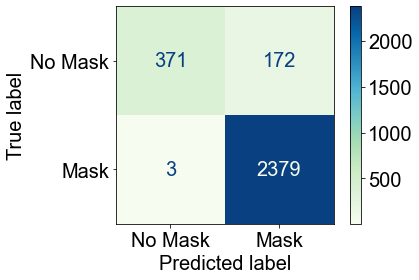

In [153]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial" # set default font to Arial
matplotlib.rcParams['font.family'] = "sans-serif" # ALWAYS use sans-serif fonts
matplotlib.rcParams['font.size'] = 20
fig, ax = plt.subplots()

cm = confusion_matrix(y_test,[int(round(x,0)) for x in list(pred[:,0])])#pred,y_test[:,0])
tn, fp, fn, tp = cm.ravel()
print("TN:",tn," FP:",fp," FN:",fn," TP:",tp)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["No Mask","Mask"])
disp.plot(cmap='GnBu',ax=ax)
title = 'Mask Detection Model'
# ax.set_title('Title')
plt.savefig('plots/'+title.replace(" ","_")+"_confusion_matrix.png",dpi=300,bbox_inches="tight",transparent=True)



<a id='ml'></a>

# ML Model Fitting


### Reshape data For sklearn model fitting:

In [253]:
# training set
x_train = np.array(x_train).reshape(-1,50,50)
nsamples, nx, ny = x_train.shape
x_train = x_train.reshape((nsamples,nx*ny))
# normalize data - if don't logistic regression does not converge
from sklearn import preprocessing
x_train = preprocessing.normalize(x_train)

#testing set
x_test = np.array(x_test).reshape(-1,50,50)
nsamples, nx, ny = x_test.shape
x_test = x_test.reshape((nsamples,nx*ny))
# normalize data - if don't logistic regression does not converge
from sklearn import preprocessing
x_test = preprocessing.normalize(x_test)

print(len(x_train))
print(len(y_train))
print()
print(len(x_test))
print(len(y_test))



8772
2924

35091
11697


In [254]:
def assess_classifier(clf, x_train, y_train, x_test, y_test):
    '''
    Assesses the inputted classifier (clf) 
    parameters:
        clf: sklearn classifier
        x_train: list training features
        y_train: list of training labels
        x_test: list of features for evaluating 
        y_test: list of labels for evaluating
    
    prints scores on training and testing sets
    
    returns:
        sc_train: score of classifier on training set
        sc_test: score of classifier on testing set
        pred_train: list of predicted labels from training set prediction
        pred_test: list of predicted labels from testing set prediction
        probs_test: list of predicted class probabilities for x_test
    '''
    # score
    sc_train = clf.score( x_train, y_train ) 
    sc_test  = clf.score( x_test,  y_test  ) 

    # predict
    pred_train = clf.predict( x_train )
    pred_test  = clf.predict( x_test  )
    
    # probabilities
    try:
        probs_test = clf.predict_proba( x_test)
    except:
        probs_test = []
        print(clf,"does not have probabilities")
    
    # print scores 
    print("Score on Training set:",sc_train)
    print("Score on Testing set:",sc_test)
    return(sc_train, sc_test, pred_train, pred_test, probs_test)
    





In [255]:
clf_ls = [] # list of classifiers 
fit_ct = 0 # to monitor status of fitting

### Logistic Regression

In [256]:
# fit classifier
from sklearn.linear_model import LogisticRegression
clf_ls.append(
    LogisticRegression().fit(x_train,y_train)
) # fit and add classifier to list 

fit_ct+=1
print("Fitting classifier",fit_ct,"complete")



ValueError: Found input variables with inconsistent numbers of samples: [8772, 2924]

### Linear SVM

In [72]:
# fit classifier
from sklearn.svm import LinearSVC
clf_ls.append(
    LinearSVC().fit(x_train,y_train)
) # fit and add classifier to list 
fit_ct+=1
print("Fitting classifier",fit_ct,"complete")



Fitting classifier 2 complete


### SVM

In [24]:
# fit classifier
from sklearn.svm import SVC
clf_ls.append(
    SVC(kernel='linear',probability=True).fit(x_train,y_train)
) # fit and add classifier to list 
fit_ct+=1
print("Fitting classifier",fit_ct,"complete")

# fit classifier
from sklearn.svm import SVC
clf_ls.append(
    SVC(kernel='rbf',probability=True).fit(x_train,y_train)
) # fit and add classifier to list 
fit_ct+=1
print("Fitting classifier",fit_ct,"complete")

# fit classifier
from sklearn.svm import SVC
clf_ls.append(
    SVC(kernel='poly',probability=True).fit(x_train,y_train)
) # fit and add classifier to list 
fit_ct+=1
print("Fitting classifier",fit_ct,"complete")

# fit classifier
from sklearn.svm import SVC
clf_ls.append(
    SVC(kernel='sigmoid',probability=True).fit(x_train,y_train)
) # fit and add classifier to list 
fit_ct+=1
print("Fitting classifier",fit_ct,"complete")

Fitting classifier 3 complete
Fitting classifier 4 complete
Fitting classifier 5 complete
Fitting classifier 6 complete


### K-Nearest-Neighbors - distance weights

In [25]:
# fit classifier
from sklearn.neighbors import KNeighborsClassifier
clf_ls.append(
    KNeighborsClassifier(n_neighbors=2,weights='distance').fit(x_train,y_train)
) # fit and add classifier to list 
fit_ct+=1
print("Fitting classifier",fit_ct,"complete")

# fit classifier
from sklearn.neighbors import KNeighborsClassifier
clf_ls.append(
    KNeighborsClassifier(n_neighbors=5,weights='distance').fit(x_train,y_train)
) # fit and add classifier to list 
fit_ct+=1
print("Fitting classifier",fit_ct,"complete")

# fit classifier
from sklearn.neighbors import KNeighborsClassifier
clf_ls.append(
    KNeighborsClassifier(n_neighbors=2,weights='distance').fit(x_train,y_train)
) # fit and add classifier to list 
fit_ct+=1
print("Fitting classifier",fit_ct,"complete")

# fit classifier
from sklearn.neighbors import KNeighborsClassifier
clf_ls.append(
    KNeighborsClassifier(n_neighbors=10,weights='distance').fit(x_train,y_train)
) # fit and add classifier to list 
fit_ct+=1
print("Fitting classifier",fit_ct,"complete")

Fitting classifier 7 complete
Fitting classifier 8 complete
Fitting classifier 9 complete
Fitting classifier 10 complete


### K-Nearest-Neighbors - uniform weights

In [26]:
# fit classifier
from sklearn.neighbors import KNeighborsClassifier
clf_ls.append(
    KNeighborsClassifier(n_neighbors=2,weights='uniform').fit(x_train,y_train)
) # fit and add classifier to list 
fit_ct+=1
print("Fitting classifier",fit_ct,"complete")

# fit classifier
from sklearn.neighbors import KNeighborsClassifier
clf_ls.append(
    KNeighborsClassifier(n_neighbors=5,weights='uniform').fit(x_train,y_train)
) # fit and add classifier to list 
fit_ct+=1
print("Fitting classifier",fit_ct,"complete")

# fit classifier
from sklearn.neighbors import KNeighborsClassifier
clf_ls.append(
    KNeighborsClassifier(n_neighbors=2,weights='uniform').fit(x_train,y_train)
) # fit and add classifier to list 
fit_ct+=1
print("Fitting classifier",fit_ct,"complete")

# fit classifier
from sklearn.neighbors import KNeighborsClassifier
clf_ls.append(
    KNeighborsClassifier(n_neighbors=10,weights='uniform').fit(x_train,y_train)
) # fit and add classifier to list 
fit_ct+=1
print("Fitting classifier",fit_ct,"complete")

Fitting classifier 11 complete
Fitting classifier 12 complete
Fitting classifier 13 complete
Fitting classifier 14 complete


# Assess performance of each classifier in clf_ls
### And Plot confusion matrices for ML fitting

2 classifiers to assess

Assessing Classifier:
 LogisticRegression()
Score on Training set: 0.7948016415868673
Score on Testing set: 0.8033683850559973

Assessing Classifier:
 LinearSVC()
LinearSVC() does not have probabilities
Score on Training set: 0.8054035567715458
Score on Testing set: 0.8014875609130546
Test set masks: 2278
Test set no masks: 9419
TN: 10  FP: 2268  FN: 32  TP: 9387
TN: 90  FP: 2188  FN: 134  TP: 9285


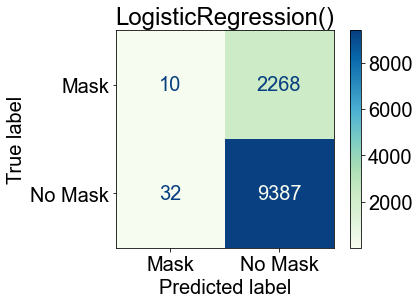

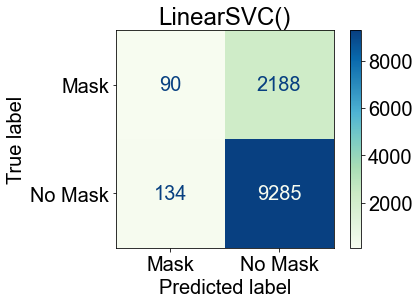

In [73]:

clf_score_ls = [] # 2D list of classifier scores [sc_train, sc_test]
clf_probs_ls = [] # list of probabilities for x_test for classifiers 
clf_names_ls = [] # list of classifier names
clf_pred_train_ls = [] # list of predicted labels for test dataset
clf_pred_test_ls = [] # list of predicted labels for training dataset
print(len(clf_ls),"classifiers to assess")
for c in clf_ls:
    print("\nAssessing Classifier:\n",c)
    clf_names_ls.append(str(c))
    sc_train, sc_test, pred_train, pred_test, probs_test = assess_classifier(c, x_train, y_train, x_test, y_test)
    
    clf_pred_train_ls.append(pred_train)
    clf_pred_test_ls.append(pred_test)
    
    clf_score_ls.append([sc_train, sc_test])
    clf_probs_ls.append(probs_test)

print("Test set masks:",len([x for x in y_test if x==0]))
print("Test set no masks:",   len([x for x in y_test if x==1]))



from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt

# Change default matplotlib plotting paramters
import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial" # set default font to Arial
matplotlib.rcParams['font.family'] = "sans-serif" # ALWAYS use sans-serif fonts
matplotlib.rcParams['font.size'] = 20


for i in range(len(clf_pred_test_ls)):
    
    fig, ax = plt.subplots()
    
    cm = confusion_matrix(y_test,clf_pred_test_ls[i])
    tn, fp, fn, tp = cm.ravel()
    print("TN:",tn," FP:",fp," FN:",fn," TP:",tp)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["Mask","No Mask"])
    disp.plot(cmap='GnBu',ax=ax)
    ax.set_title(clf_ls[i])
    plt.savefig('plots/'+str(clf_ls[i])+"_confusion_matrix.png",dpi=300,bbox_inches="tight",transparent=True)
#     plt.show()
    
# # TODO: plot ROC Curve
# from sklearn import metrics
# fpr, tpr, thresholds = metrics.roc_curve(y, scores, pos_label=2)
# fpr

# tpr

# thresholds
# # TODO: plot Precision Recall Curve





